<a href="https://colab.research.google.com/github/christdinga/hse_dm/blob/main/06-model-evaluation/QualityMetrics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [48]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [49]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [50]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.8600000000000001


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

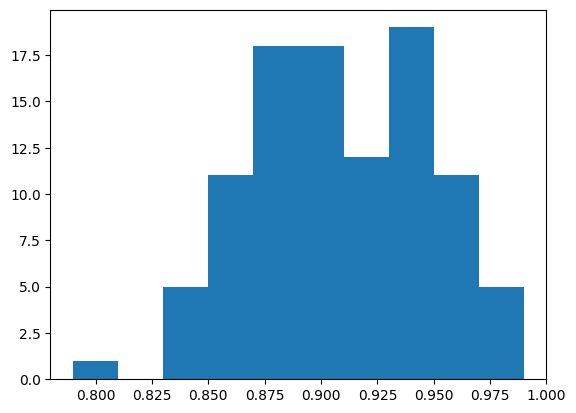

In [51]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

In [52]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.arange(len(X))

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook).

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
```

In [53]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

--2024-11-04 20:41:48--  https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv.3’

train.csv.3         100%[===================>]  58.89K  --.-KB/s    in 0.04s   

2024-11-04 20:41:48 (1.39 MB/s) - ‘train.csv.3’ saved [60302/60302]



In [54]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

dataset = pd.read_csv("train.csv", index_col='PassengerId')

In [55]:
dataset['is_NaN'] = (dataset['Age'].isnull()) | (dataset['Cabin'].isnull())
features = dataset[['Pclass' , 'Sex' , 'Age' , 'SibSp' , 'Parch' , 'Age' , 'Parch' , 'Fare' , 'is_NaN']].copy()
#features = dataset[["SibSp", "Parch", "Sex", "Pclass", "Fare", 'is_NaN']].copy()
features["Age"] = dataset.Age.fillna(dataset.Age.median())
label_encoder = LabelEncoder()
features['is_NaN'] = label_encoder.fit_transform(features['is_NaN'])
features['Sex'] = label_encoder.fit_transform(features['Sex'])

In [56]:
model = LogisticRegression(max_iter=300)
params = {'penalty': ['l1' , 'l2' , 'elasticnet', None],
          'C': [0.15 , 0.2 , 0.25 , 0.5 , 0.8 , 1 , 1.5 , 2,] ,
          'solver': ['lbfgs' , 'liblinear' , 'newton-cg' , 'newton-cholesky' , 'sag']
          }
grid_s = GridSearchCV(model , params)
grid_s.fit(features , dataset['Survived'])
grid_s.best_params_

{'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'}

In [58]:
def feature_selection_and_preprocessing(dataset):
  # <YOUR CODE>
  # E.g.:
  dataset['is_NaN'] = (dataset['Age'].isnull()) | (dataset['Cabin'].isnull())
  features = dataset[['Pclass' , 'Sex' , 'Age' , 'SibSp' , 'Parch' , 'Parch' , 'Fare' , 'is_NaN']].copy()
  features['Age'] = dataset.Age.fillna(dataset.Age.median())
  label_encoder = LabelEncoder()
  features['is_NaN'] = label_encoder.fit_transform(features['is_NaN'])
  features['Sex'] = label_encoder.fit_transform(features['Sex'])

  return features

model = LogisticRegression(penalty = 'l2' , C = 0.2 , solver = 'lbfgs')


# Validation code (do not touch)
data = pd.read_csv("train.csv" , index_col='PassengerId')
data_train, data_test = train_test_split(data , test_size=200 , random_state=42)

model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived' , axis=1)
    ),
    data_train['Survived']
)

train_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_train.drop('Survived' , axis=1)
    )
)

test_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived' , axis=1)
    )
)

print("Current Train accuracy:" , accuracy_score(
    data_train['Survived'] ,
    train_predictions
))
print("Current Test accuracy:" , accuracy_score(
    data_test['Survived'] ,
    test_predictions
))

Current Train accuracy: 0.7959479015918958
Current Test accuracy: 0.83


Previous Train accuracy: 0.7945007235890015

Previous Test accuracy: 0.825
